# BG/NBD Model with covariates

In this notebook we show how to fit a BG/NBD model in PyMC-Marketing. We compare the results with the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package (no longer maintained). The model is presented in the paper: Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). [“Counting your customers” the easy way: An alternative to the Pareto/NBD model. Marketing science, 24(2), 275-284.](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf)

## Prepare Notebook

In [36]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import BetaGeoFitter

from pymc_marketing import clv
from pymc_marketing.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

## Read Data

We use the `ApparelTrans` dataset (see lifetimes [CLVTools Walkthrough](https://www.clvtools.com/articles/CLVTools.html)).

In [37]:
data_path = "./data/apparel_trans.csv"

raw_trans = pd.read_csv(data_path, index_col="Unnamed: 0")
raw_trans.columns = [col.lower() for col in raw_trans.columns]
raw_trans["date"] = pd.to_datetime(raw_trans["date"])
raw_trans.head()

,id,date,price
1,1,2005-01-02,230.30
2,1,2005-09-06,84.39
3,1,2006-01-18,131.07
4,1,2006-04-05,86.43
5,1,2006-07-02,11.49


```{tip}
We rename the index column to `customer_id` as this is required by the model
```

In [38]:
data = (
    raw_trans
    .rename(columns={"id": "customer_id", "price": "monetary_value"})
)

In [39]:
rfm_data = clv.rfm_summary(data, customer_id_col = "customer_id", datetime_col="date")

Recall from the `lifetimes` documentation the following definitions:

> - `frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
> - `T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

## Time-invariat covariates

In [40]:
data_path = "./data/apparel_static_cov.csv"

covar_df = pd.read_csv(data_path, index_col="Unnamed: 0")
covar_df.columns = [col.lower() for col in covar_df.columns]
covar_df = covar_df.rename(columns={"id": "customer_id"})
covar_df.head()

,customer_id,gender,channel
1,1,0,0
2,2,1,0
3,3,1,0
4,4,1,0
5,5,1,0


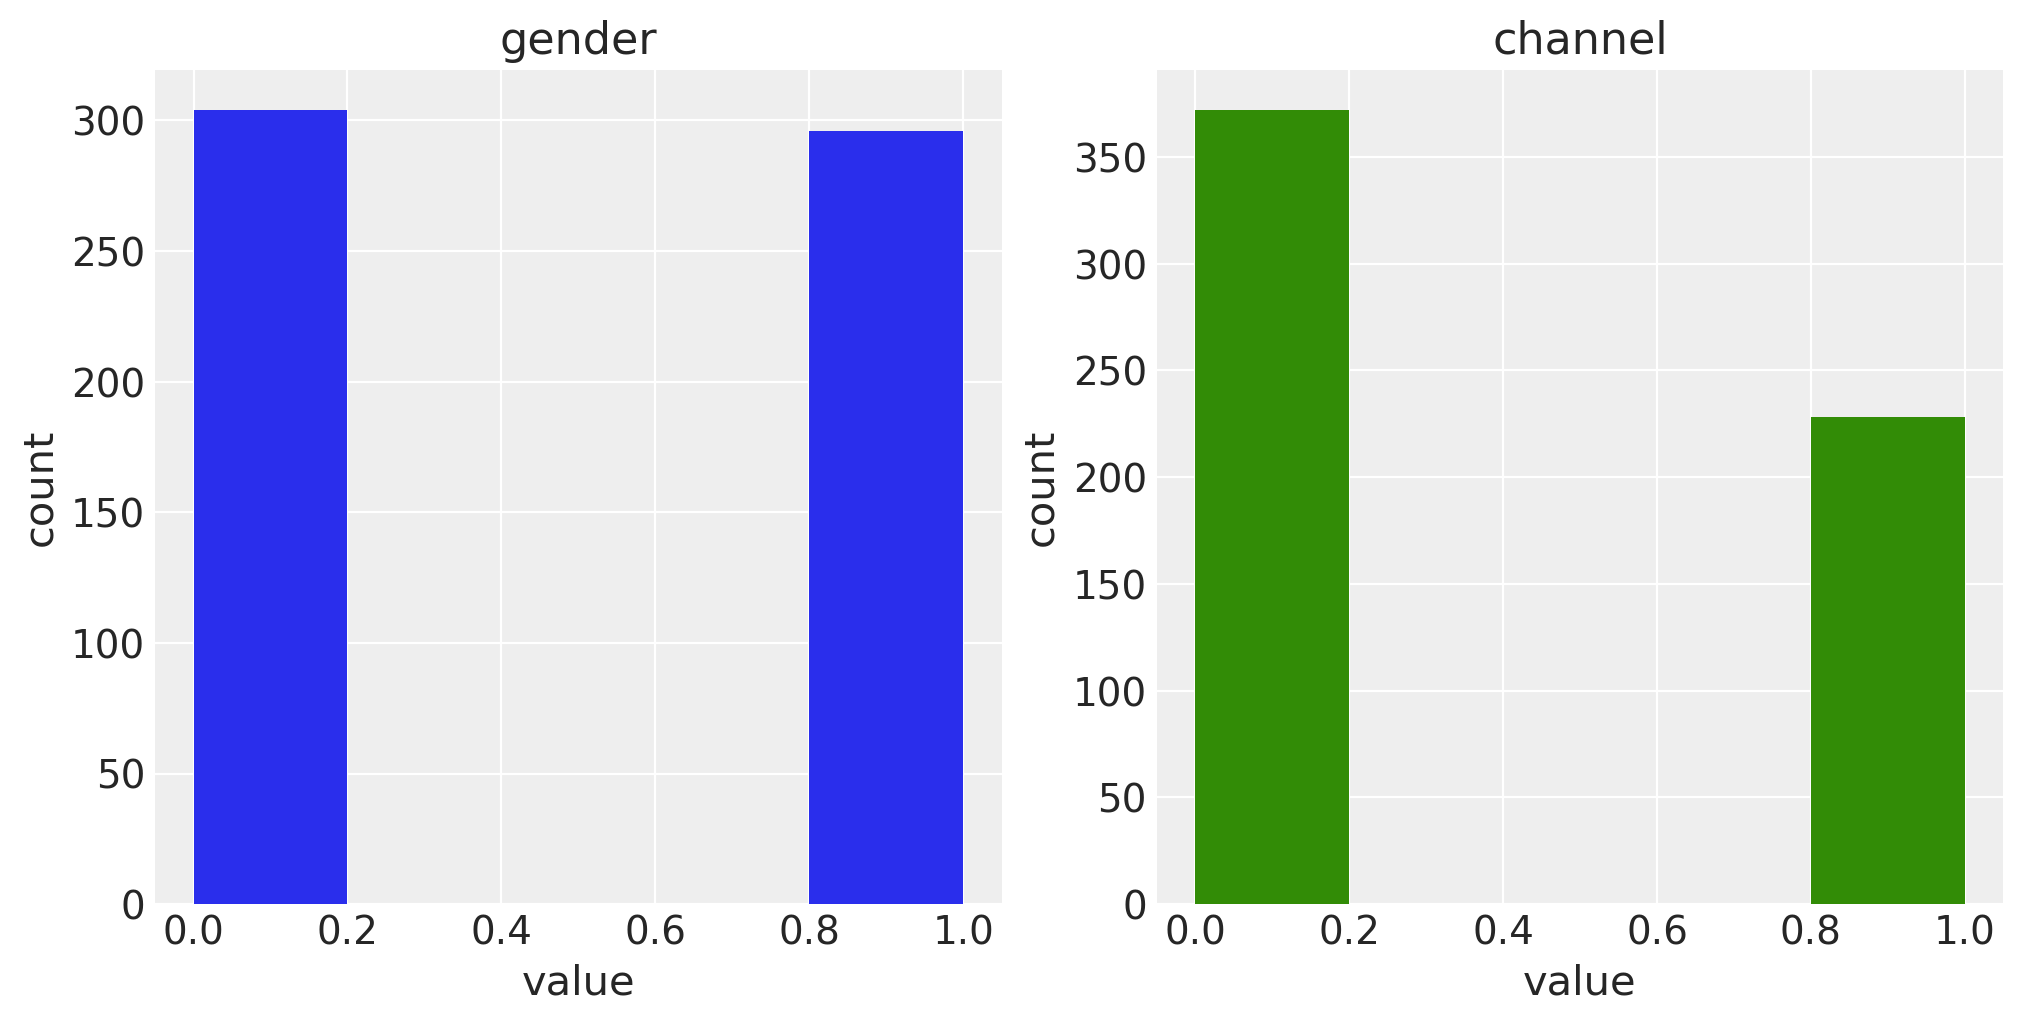

In [41]:

# plot covariate histograms
_, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    layout="constrained",
)

axes = axes.flatten()

covars = ["gender", "channel"]
colors = ["C0", "C2"]

for ax in zip(axes, covars, colors, strict=False):
    ax[0].hist(
        x=covar_df[ax[1]],
        bins=5,
        color=ax[2],
    )
    ax[0].set(title=f"{ax[1]}", xlabel="value", ylabel="count")

We have categorical dummy variables.

In [42]:
rfm_covar = rfm_data.merge(covar_df, left_on="customer_id", right_on="customer_id", how="inner")

## Fit without covariates

In [43]:
model_config={
    "alpha_prior": Prior("Normal", mu=1, sigma=0.1),
    "a_prior": Prior("Normal", mu=1, sigma=0.1),
    "b_prior": Prior("Normal", mu=1, sigma=0.1),
}

In [44]:
bgnbd = clv.BetaGeoModel(
    rfm_data,
    model_config=model_config,
)

bgnbd.build_model()
bgnbd.fit(fit_method="mcmc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a, b, r]


/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

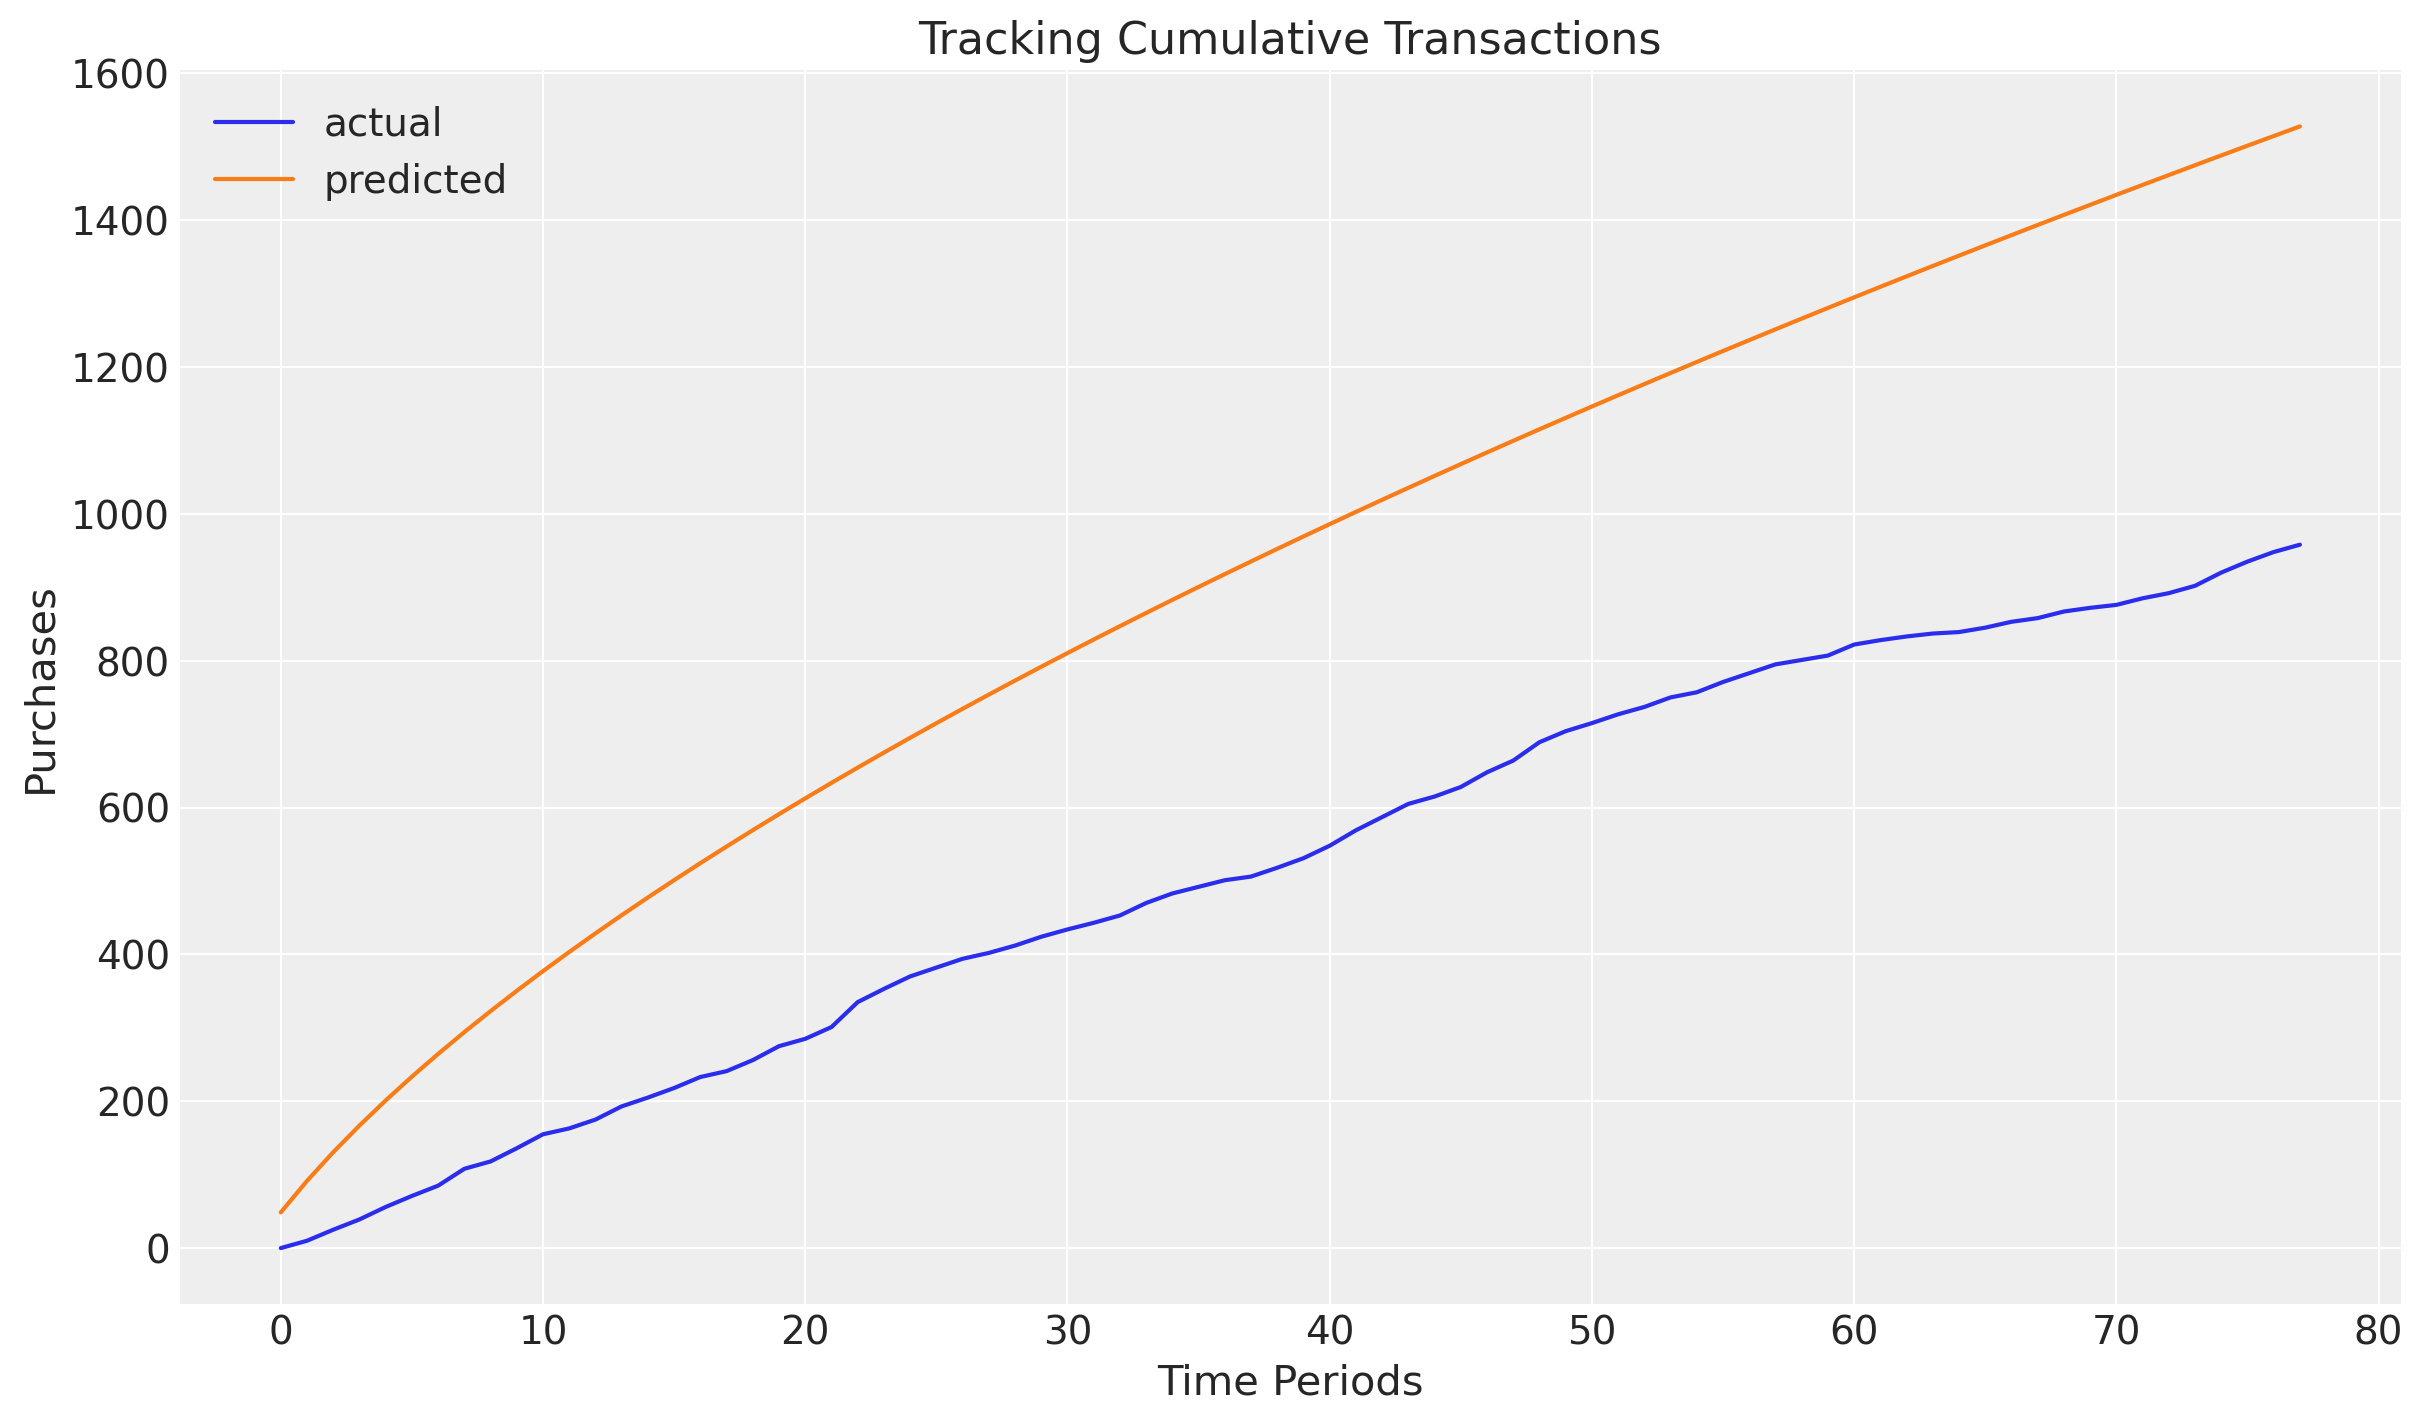

In [45]:
clv.plot_expected_purchases_over_time(
    model=bgnbd,
    #purchase_history=data,
    purchase_history=data,
    datetime_col="date",
    customer_id_col="customer_id",
    # datetime_format="%Y%m%d",
    time_unit="W",
    t=78,
);

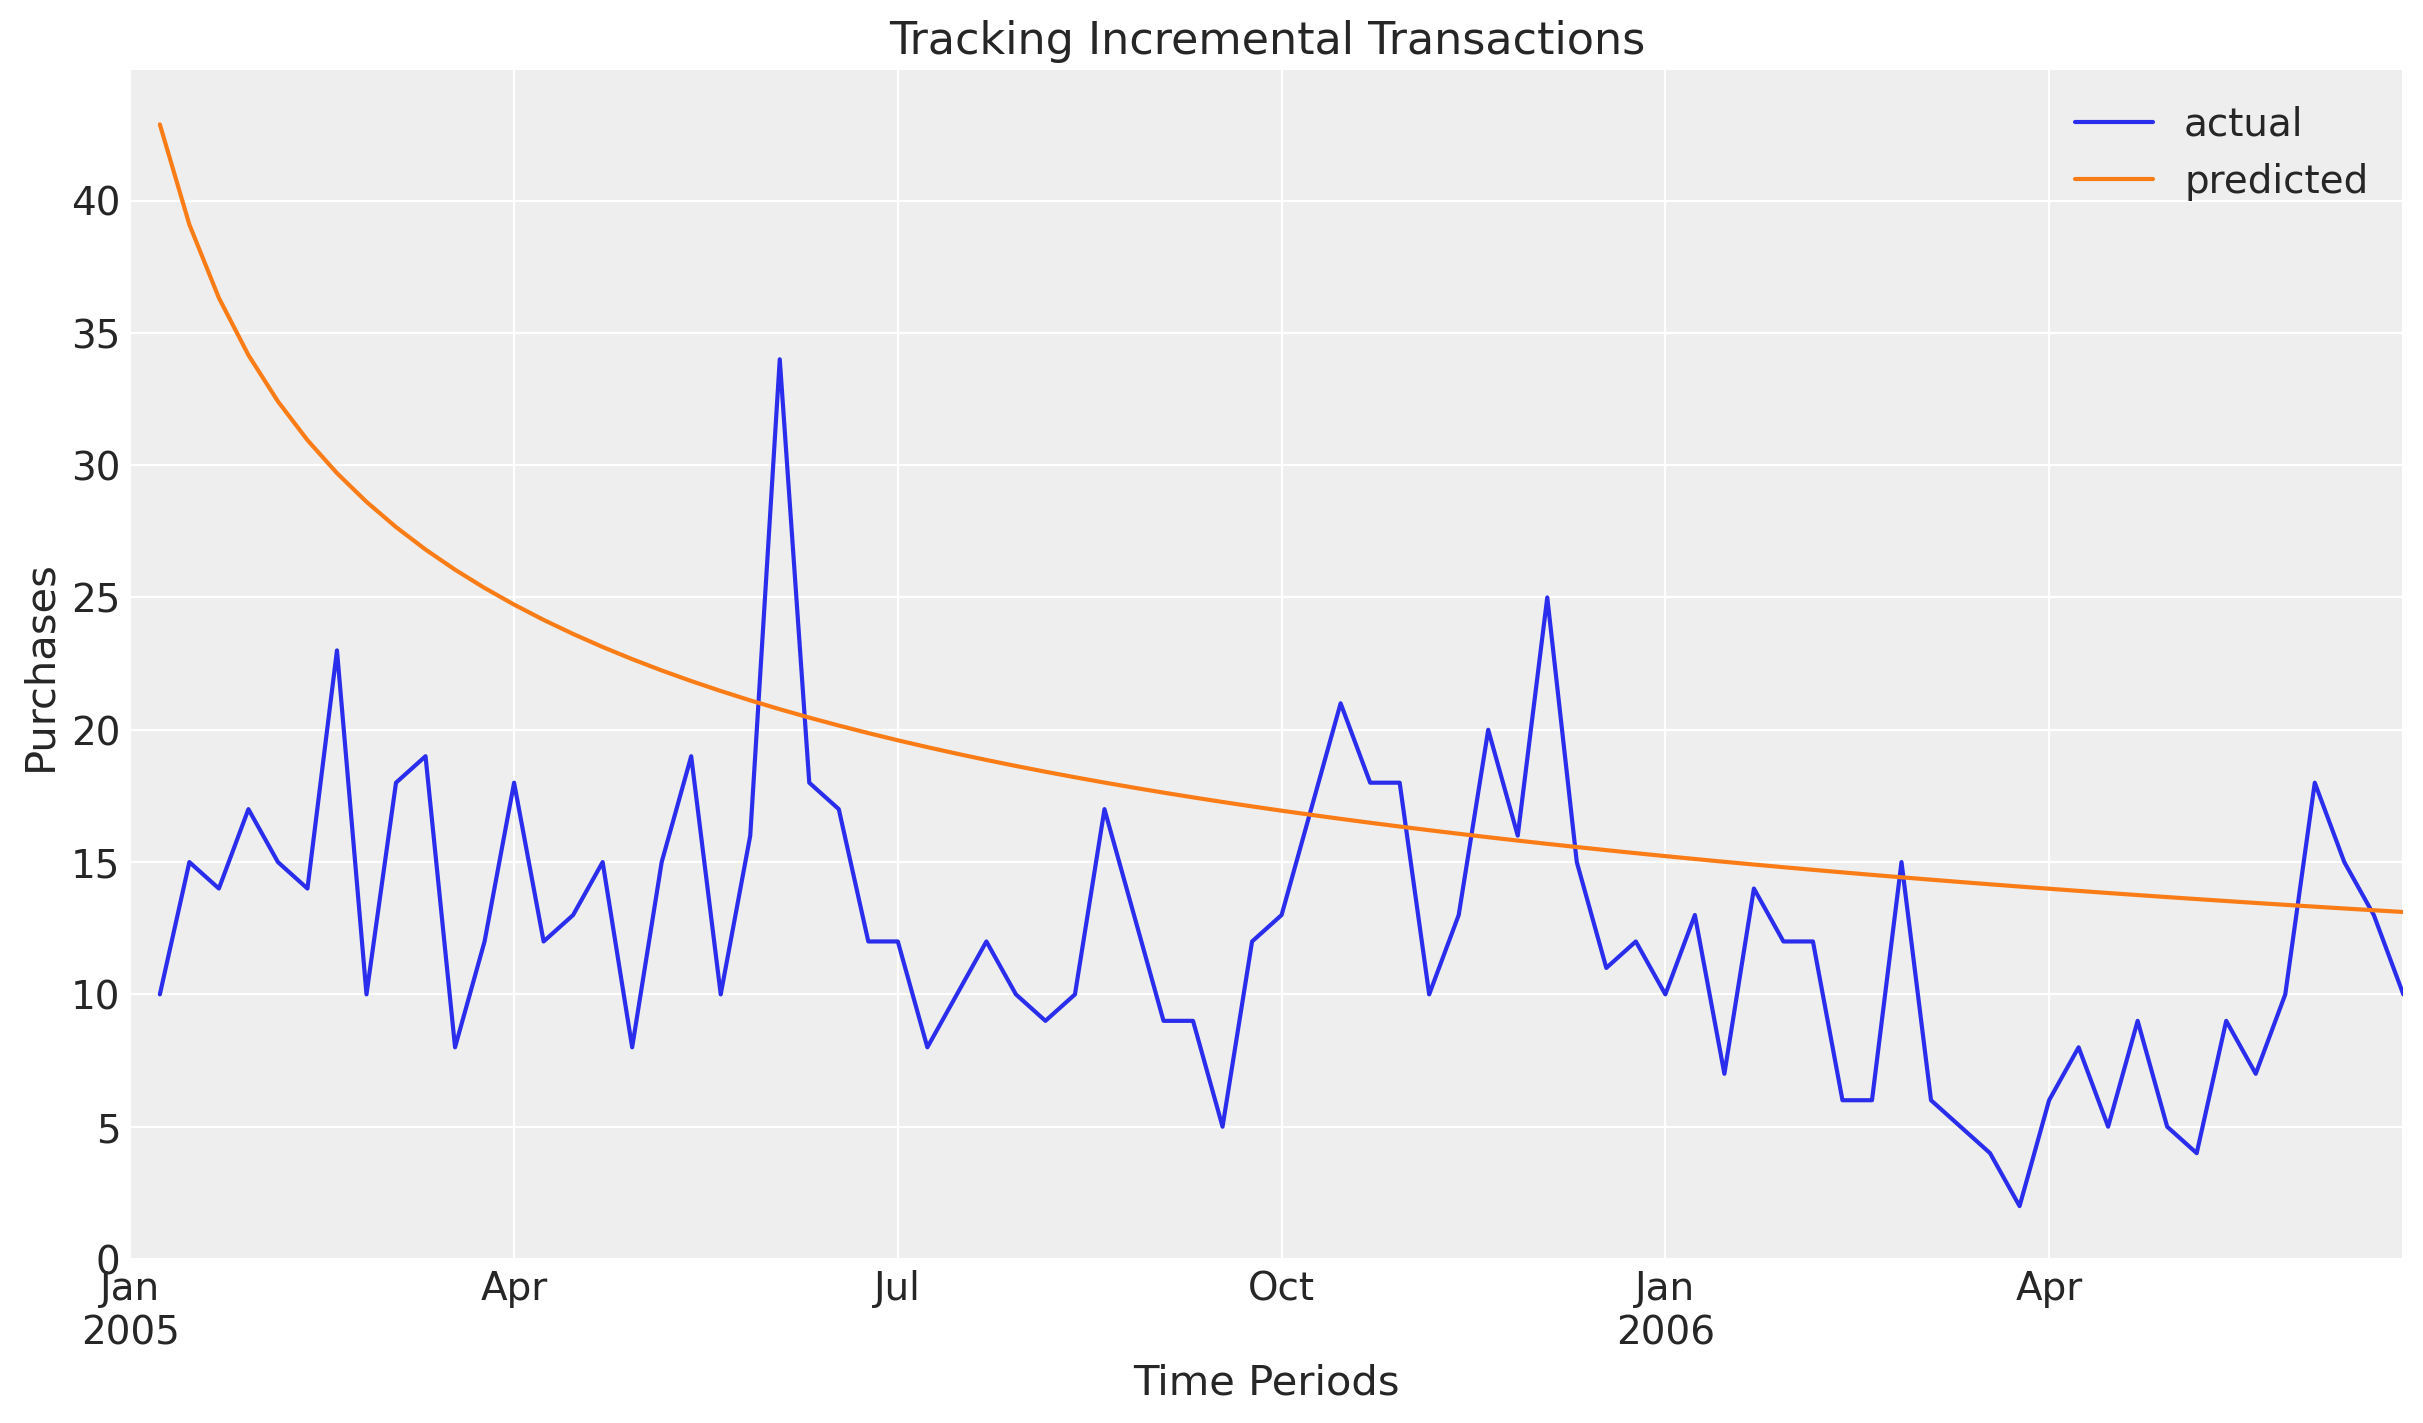

In [46]:
clv.plot_expected_purchases_over_time(
    model=bgnbd,
    #purchase_history=data,
    purchase_history=data,
    datetime_col="date",
    customer_id_col="customer_id",
    datetime_format="%Y%m%d",
    time_unit="W",
    t=78,
    set_index_date=True,
    plot_cumulative=False,
);

It looks like we have a slightly biased estimator. 

Note that this could be due to the choice of prior, since we have relatively small dataset.

## Introducing covariates

In [47]:
model_config={
    "alpha_prior": Prior("Normal", mu=1, sigma=0.1),
    "a_prior": Prior("Normal", mu=1, sigma=0.1),
    "b_prior": Prior("Normal", mu=1, sigma=0.1),
    "purchase_covariate_cols": ["gender", "channel"],
    "dropout_covariate_cols": ["gender", "channel"],
}

In [48]:
bgnbd_covar = clv.BetaGeoModel(
    rfm_covar,
    model_config=model_config,
)

bgnbd_covar.build_model()

In [49]:
bgnbd_covar.fit(fit_method="mcmc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [purchase_coefficient_alpha, alpha_scale, dropout_coefficient_a, dropout_coefficient_b, a_scale, b_scale, r]


/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

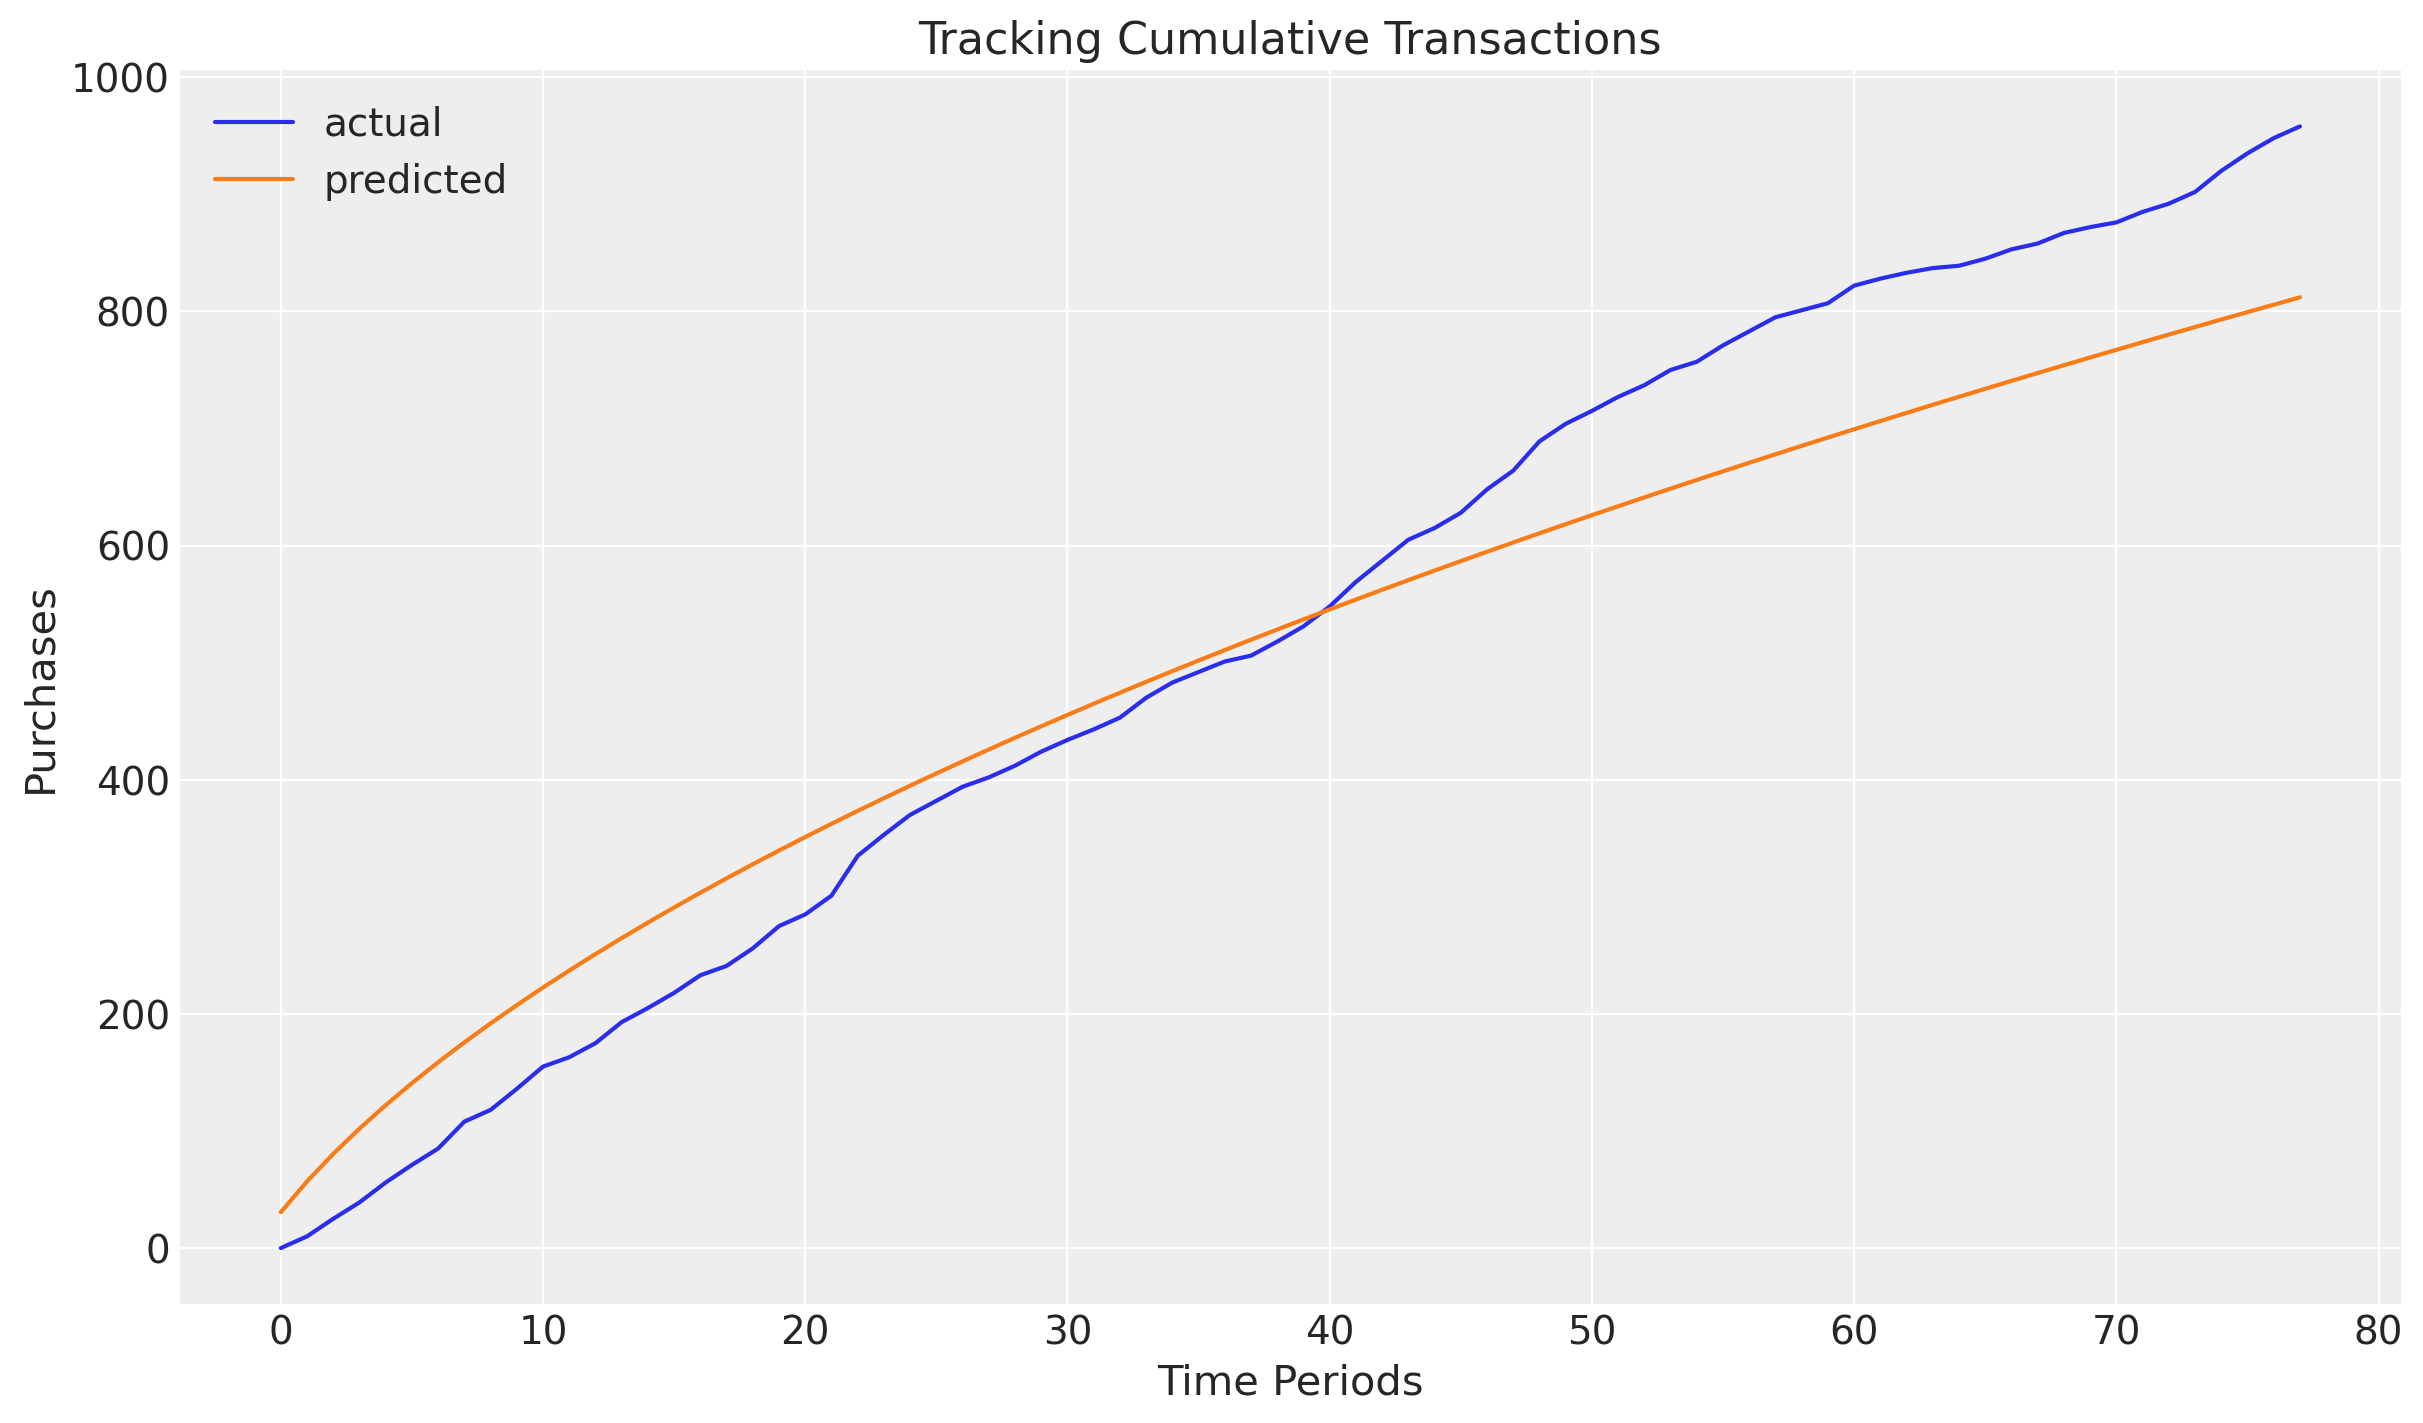

In [50]:
clv.plot_expected_purchases_over_time(
    model=bgnbd_covar,
    purchase_history=pd.merge(data, covar_df, left_on="customer_id", right_on="customer_id", how="inner"),
    datetime_col="date",
    customer_id_col="customer_id",
    # datetime_format="%Y%m%d",
    time_unit="W",
    t=78,
);

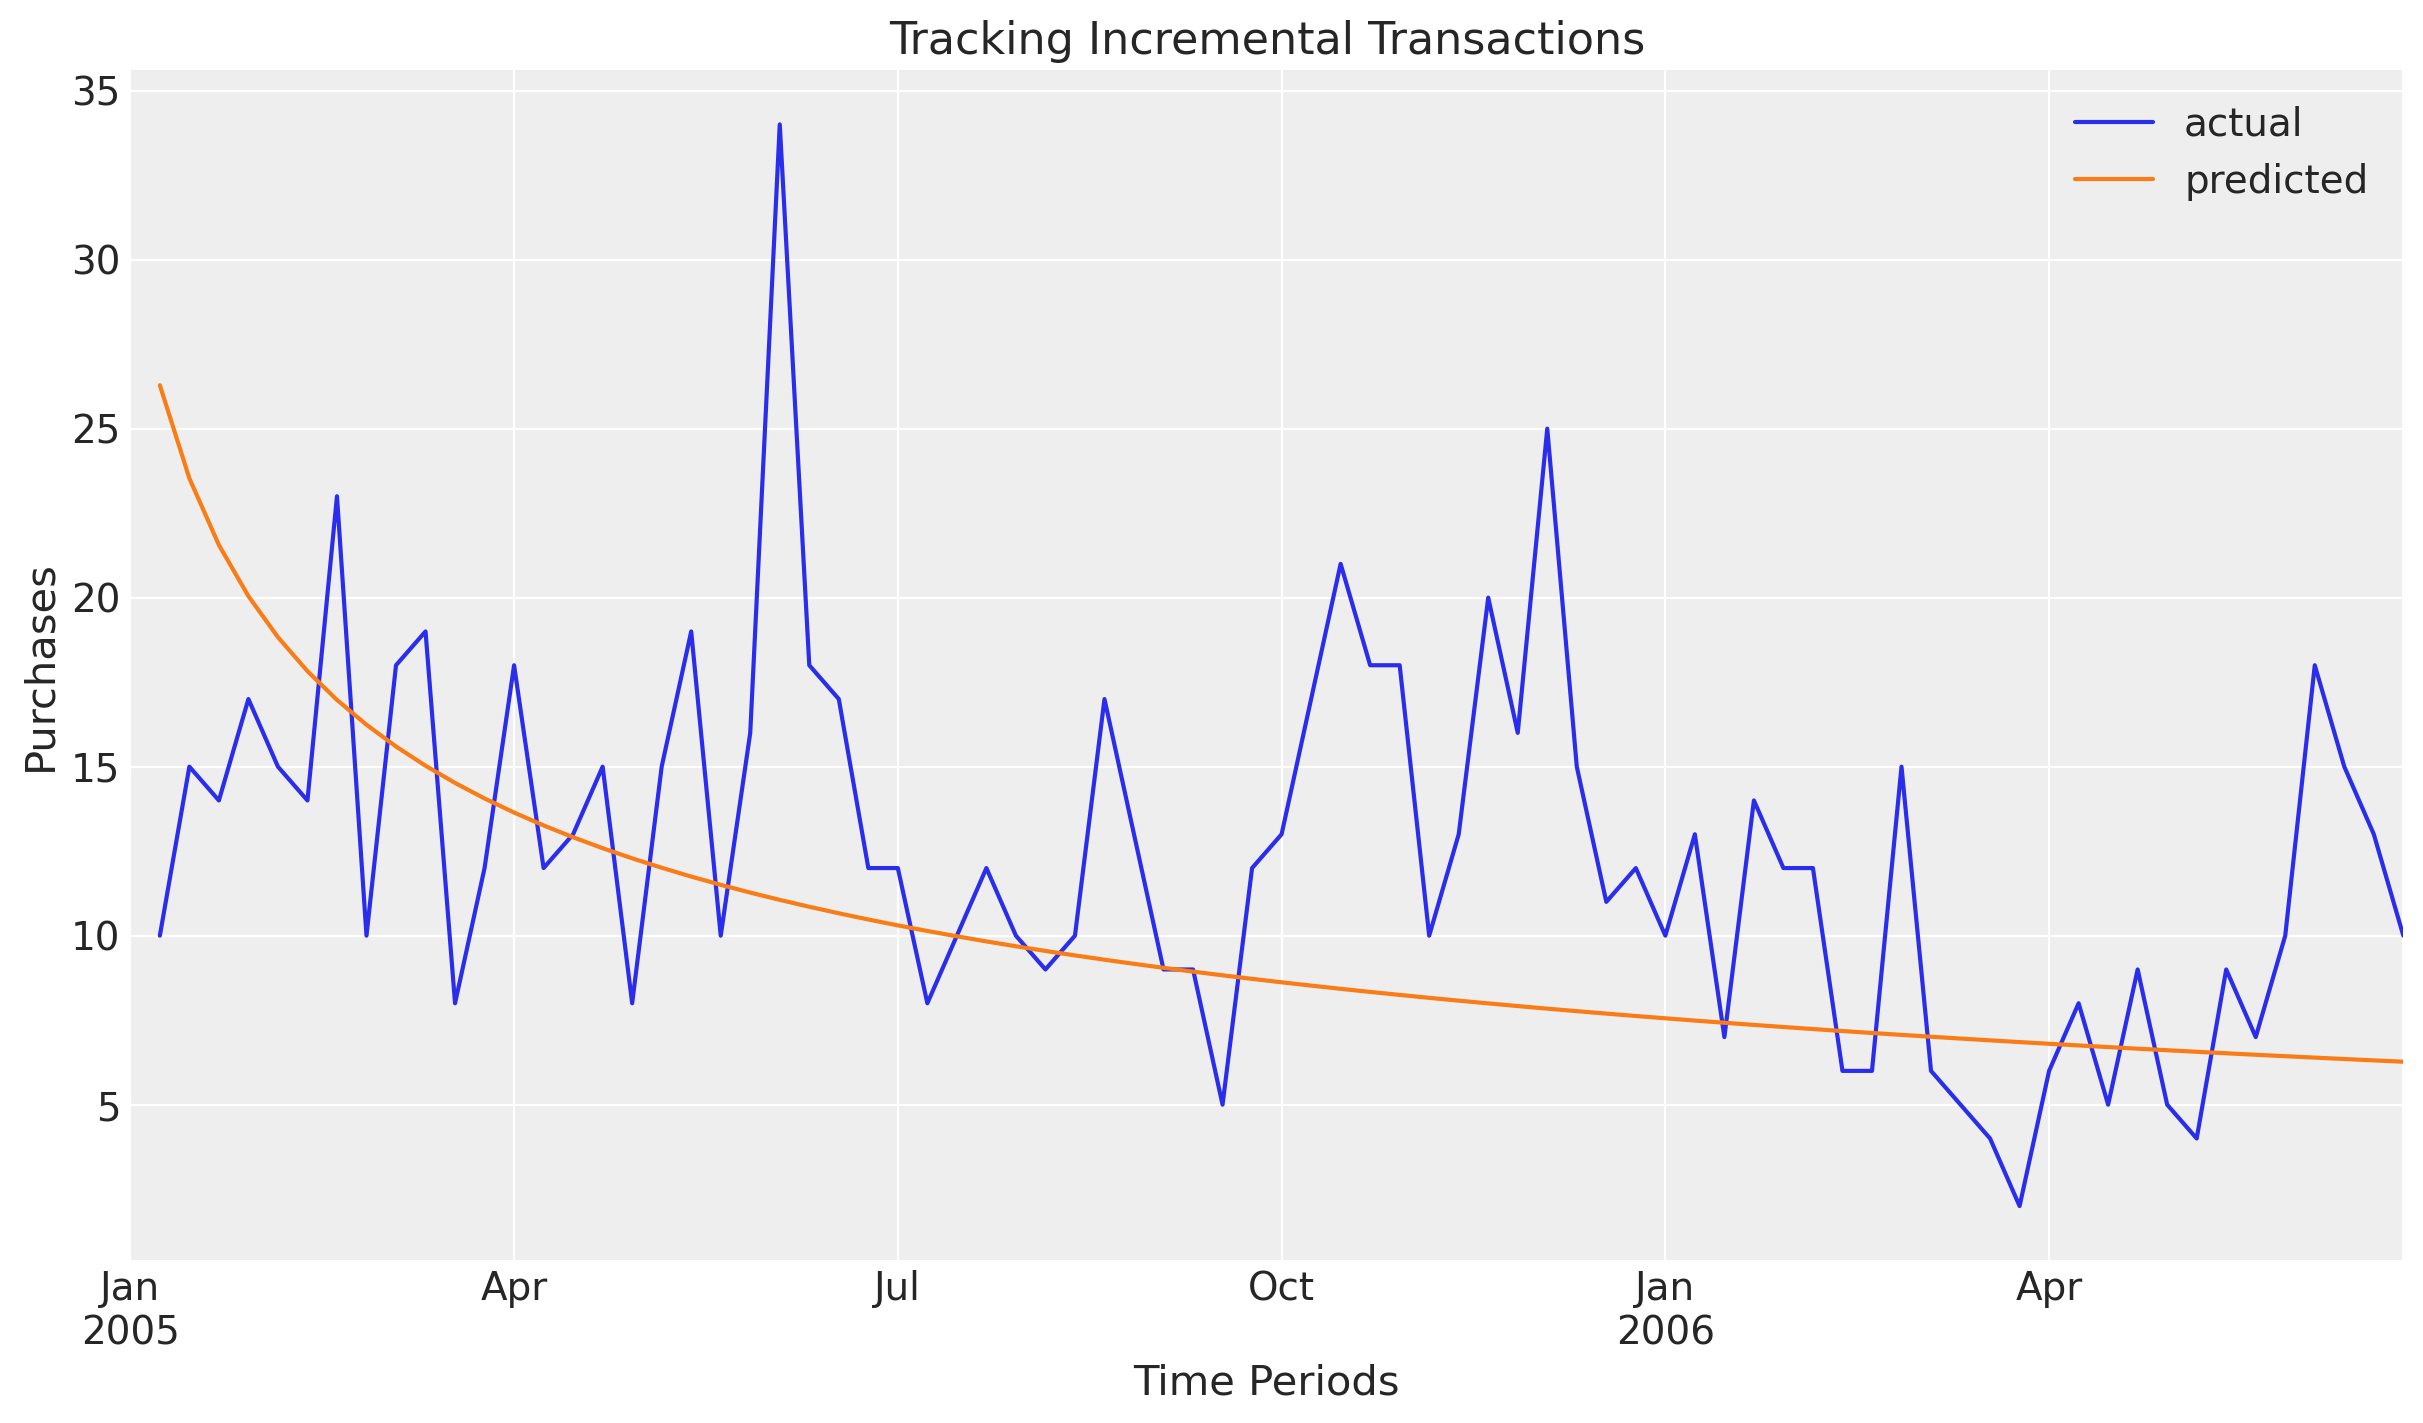

In [33]:
clv.plot_expected_purchases_over_time(
    model=bgnbd_covar,
    purchase_history=pd.merge(data, covar_df, left_on="customer_id", right_on="customer_id", how="inner"),
    datetime_col="date",
    customer_id_col="customer_id",
    datetime_format="%Y%m%d",
    time_unit="W",
    t=78,
    set_index_date=True,
    plot_cumulative=False,
);

The introduction of covariates, helps reducing the bias

In [34]:
%reload_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Feb 10 2025

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.32.0

pymc    : 5.20.0
pytensor: 2.26.4

xarray        : 2025.1.2
lifetimes     : 0.11.3
matplotlib    : 3.10.0
fastprogress  : 1.0.3
pandas        : 2.2.3
arviz         : 0.20.0
pymc_marketing: 0.11.1

Watermark: 2.5.0

